In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Change with your drive "media" folder
# !ln -s "/content/drive/MyDrive/MyTeaching/Elaborazione-Audio-Digitale/EAD26_docente/EAD-U04.analisi-audio-frequenza/media" media

In [ ]:
!git clone "https://github.com/polito-EAD-2026/EAD26-U04.analisi-audio-frequenza.git"
!mv ./EAD26-U04.analisi-audio-frequenza/* .

fatal: destination path 'EAD26-U04.analisi-audio-frequenza' already exists and is not an empty directory.
mv: cannot stat './EAD26-U04.analisi-audio-frequenza/*': No such file or directory


# Riferimenti

* [SCIPY] "Spectral Analysis"
  * https://docs.scipy.org/doc/scipy/tutorial/signal.html#tutorial-spectralanalysis
  
* [LERCH] Lerch, "An Introduction to Audio Content Analysis"
  * Ch.3.5 "Instantaneous Features"
    * Spectral Centroid, Spectral Spread, Spectral Rolloff, Zero Crossing Rate, …
  * Code: https://github.com/alexanderlerch/pyACA

* [MULLER] Muller, "Fundamentals of Music Processing"
  * Ch.2 Fourier Analysis of Signals
  * Code: https://audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html

* [PRAAT] Praat Software - praat.org
  * Weenink, "Speech Signal Processing with Praat"
  * https://www.fon.hum.uva.nl/david/sspbook/sspbook.pdf




In [1]:
# Install Librosa
!pip install -q librosa praat-parselmouth sox
!pip install -q ipympl mpl_interactions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00


In [2]:
import librosa
import librosa.display
import numpy as np
import scipy.signal as signal
import parselmouth

import matplotlib
import matplotlib.pyplot as plt


import IPython
import IPython.display as ipd

import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt

# warning: restart session after pip install ipympl
# %matplotlib widget
%matplotlib inline

from google.colab import output
output.enable_custom_widget_manager()

matplotlib.rcParams.update({'font.size': 14})

import IPython
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint

from scipy import signal

In [3]:

def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):
  fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
  ax.plot(t,w,fmt)
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Amplitude')
  ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
  ax.set_ylim(ylim) if ylim is not None else None
  fig.tight_layout()
  ax.grid(visible=True)
  # plt.show()

[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6])]

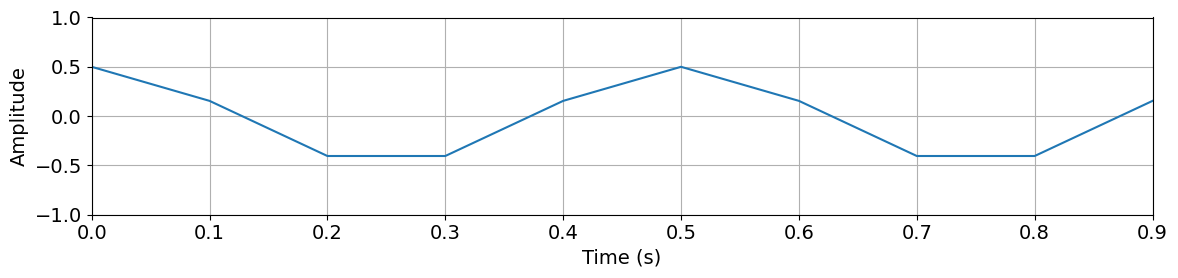

In [4]:
# Sintesi tono puro

import numpy as np
N, Fs, A, f = 10, 10, 0.5, 2
t = np.arange(N) / Fs
s = A * np.cos(2 * np.pi * f * t)
plot_vs_time(s,t)

[t, (2 * np.pi * f * t) / np.pi]

In [ ]:
# Aliasing

@interact(
    f = widgets.IntSlider(min=1, max=15, step=1, value=4, continuous_update=False),
)
def demo_aliasing(f):
  fig, ax = plt.subplots(figsize=(9,3.1))
  A = 0.5

  N, Fs = 10, 10
  t = np.arange(N) / Fs
  s = A * np.sin(2 * np.pi * f * t)
  plot_vs_time(s,t, fmt='-*', fig=(fig, ax))

  N, Fs = 100, 100
  t = np.arange(N) / Fs
  s = A * np.sin(2 * np.pi * f * t)
  plot_vs_time(s,t, fmt='-', fig=(fig, ax))

  ax.set_xlim(-0.1, 1.1)

In [6]:
def gen_cos(dur=1, Fs=100, amp=1, freq=2, phase=0):
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.cos( (2*np.pi*freq*t) + phase)
    return x, t

def gen_cos_d(dur=1, Fs=100, amp=1, freq=2, delay=0):
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.cos(2*np.pi*freq*(t-delay))
    return x, t

In [7]:
def dft(x, Fs, N=None):
  L = len(x)
  N = L if N is None else N
  X = np.fft.rfft(x, N)
  X_ = np.abs(X) / (L/2)
  freq = np.fft.rfftfreq(N, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  X_dBFS = X_ # 20*np.log10(X_)
  return X_dBFS, freq

def RMS(x):
  return np.sqrt(np.mean(x**2))

def dBFS(x):
  return 20*np.log10(RMS(x))


In [25]:
# plot frequency spectrum
def plot_vs_freq(X, f, Fs, type="linear", xlim=None, ylim=None, fig=None, zp=False, fmt="-"):

  fig, ax = plt.subplots(figsize=(6,3)) if fig is None else fig
  xlim = [np.min(f), np.max(f)] if xlim is None else xlim

  if type == "linear":
    ax.set_ylabel('Magnitude')
    ylim = [0, 1.2] if ylim is None else ylim
    X = X
  elif type == "log":
    ax.set_ylabel('Power (dBFS)')
    ylim = [-60, +6] if ylim is None else ylim
    X = 10*np.log10(X**2)

  ax.plot(f, X, fmt)
  ax.set_xlabel('Frequency (Hz)')

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.grid(visible=True);
  plt.tight_layout()

# plot_vs_freq(x, Fs, N)
# plot_vs_freq(x, Fs, N, xlim=[2, 5], ylim=[-10, 3])



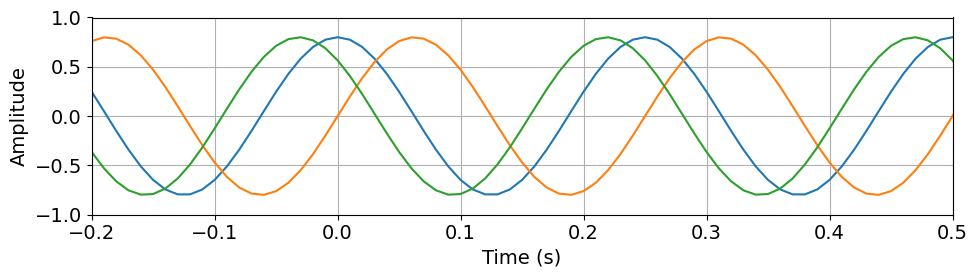

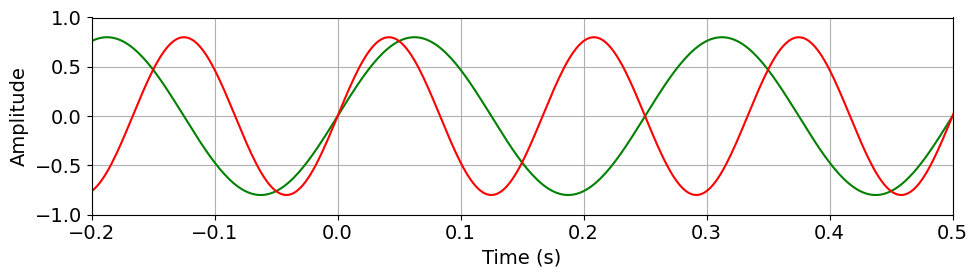

In [10]:
# EFFETTO DELLA FASE
# n.b. gen_cos e gen_cos_d implementate (come _) per generare coseno _simmetrico_ rispetto all'origine

def gen_cos_(dur=1, Fs=100, amp=1, freq=2, phase=0):
    num_samples = int(Fs * dur)
    t = np.arange(-num_samples,num_samples) / Fs
    x = amp * np.cos( (2*np.pi*freq*t) + phase)
    return x, t

def gen_cos_d_(dur=1, Fs=100, amp=1, freq=2, delay=0):
    num_samples = int(Fs * dur)
    t = np.arange(-num_samples,num_samples) / Fs
    x = amp * np.cos(2*np.pi*freq*(t-delay))
    return x, t
    f = 4

fig, ax = plt.subplots(figsize=(10,3))
f = 4
x0,t = gen_cos_(dur=1, Fs=100, amp=0.8, freq=f, phase=0)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-')
x0,t = gen_cos_(dur=1, Fs=100, amp=0.8, freq=f, phase=-np.pi/2)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-')
x0,t = gen_cos_(dur=1, Fs=100, amp=0.8, freq=f, phase=np.pi/4)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-')


fig, ax = plt.subplots(figsize=(10,3))
Fs = 500
f = 4
ph = -np.pi/2
x0,t = gen_cos_(dur=1, Fs=Fs, amp=0.8, freq=f, phase=-np.pi/2)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-g')
f = 6
x0,t = gen_cos_(dur=1, Fs=Fs, amp=0.8, freq=f, phase=-np.pi/2)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-r')


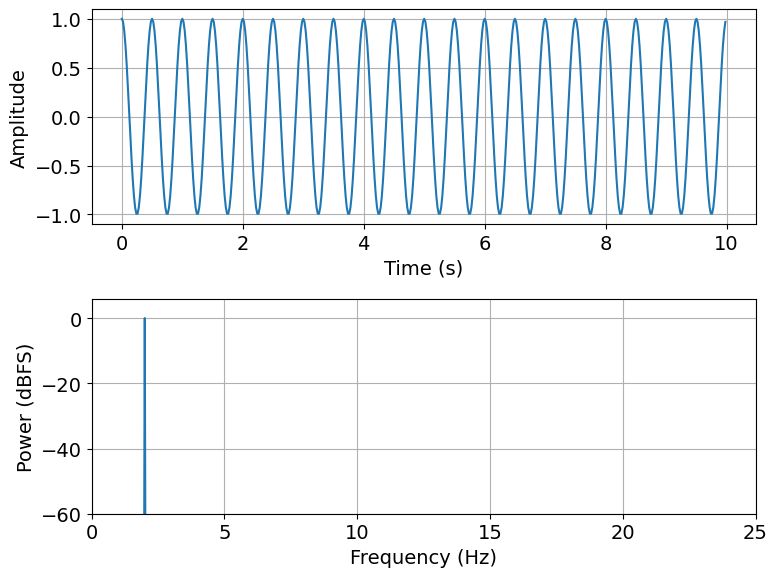

In [26]:
Fs = 50
dur = 10
x, t = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)

fig, ax = plt.subplots(2,1,figsize=(8,6))
plot_vs_time(x, t, ylim = [-1.1, +1.1], fig=(fig,ax[0]))

X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, type="log", fig=(fig,ax[1]))

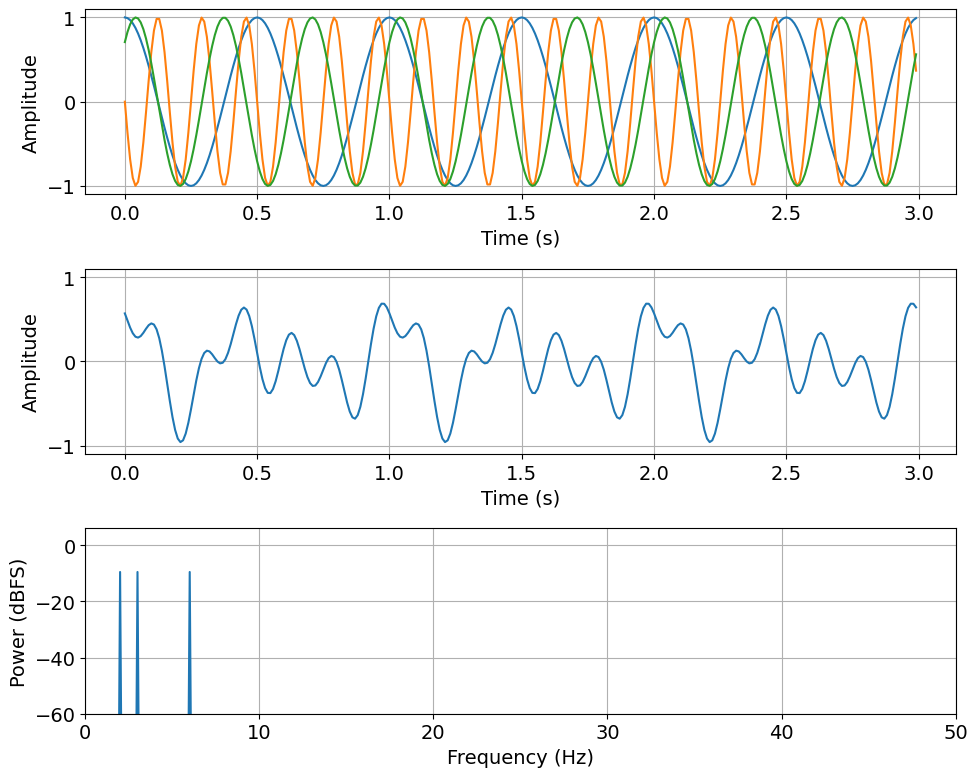

"\nplt.figure()\nf, X = signal.periodogram(x, Fs, scaling='spectrum')\nplt.plot(f, 10*np.log10(X))\nplt.ylim([-60, 0])\nplt.grid()\nplt.show()\n"

In [28]:
# RAPPRESENTAZIONE NEL DOMINIO DELLA FREQUENZA
# SUONI COMPLESSI: SOMMA DI TONI PURI

Fs = 100
dur = 3

# tono 2 Hz
x1, t1 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)
# tono 6 Hz
x2, t2 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=6, phase=np.pi/2)
# tono 3 Hz
x3, t3 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=3, phase=-np.pi/4)

# tono np.sqrt(2)
x4, t3 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=3, phase=-0)

# Componenti del segnale complesso xx
xx = [x1, x2, x3] # periodic
# xx = [x1, x2, x4] # non periodic

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(10,8))
for x_ in xx:
  plot_vs_time(x_, t1,  ylim = [-1.1, +1.1], fig=(fig,ax1))

# Media somma dei toni
x = np.average(xx, axis=0)
t = t1

# fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,5))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax2), fmt='-')
X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, type="log", fig=(fig,ax3))

plt.show()

"""
plt.figure()
f, X = signal.periodogram(x, Fs, scaling='spectrum')
plt.plot(f, 10*np.log10(X))
plt.ylim([-60, 0])
plt.grid()
plt.show()
"""


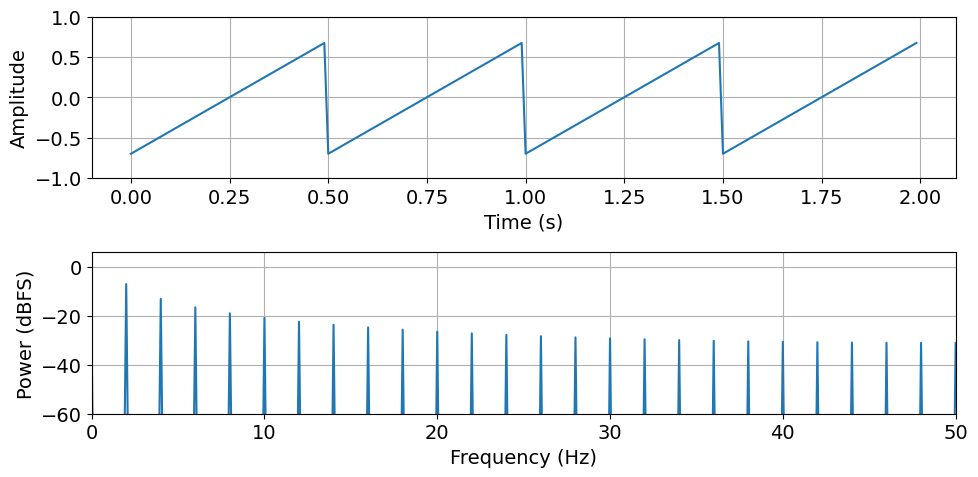

2.0: 0.00
4.0: 0.22
6.0: 0.30
8.0: 0.33
10.0: 0.36
12.0: 0.37
14.0: 0.38
16.0: 0.39


In [30]:
# INVILUPPO SPETTRALE

from scipy.signal import sawtooth, find_peaks


Fs = 100
dur = 2
f0 = 2
A = 0.7
t = np.arange(dur*Fs)/Fs

x = A * signal.sawtooth(2 * np.pi * f0 * t)
# x = A * signal.square(2 * np.pi * f0 * t)


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,5))

plot_vs_time(x, t, fig=(fig,ax1))

X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, type="log", fig=(fig,ax2))
plt.show()

"""
plt.figure(figsize=(10,3))
plt.magnitude_spectrum(x, Fs=Fs, scale='dB')
plt.ylim([-60, 0])
plt.grid()
plt.show()

plt.figure(figsize=(10,3))
f, X = signal.periodogram(x, Fs, scaling='spectrum')
plt.plot(f, 10*np.log10(X))
plt.ylim([-60, 0])
plt.grid()
plt.show()
"""

peaks, _ = find_peaks(X)  # tune distance as needed
p0 = peaks[0]
for p in peaks[0:8]:
  print(f"{f[p]}: {X[p0]-X[p]:.2f}")

# Features

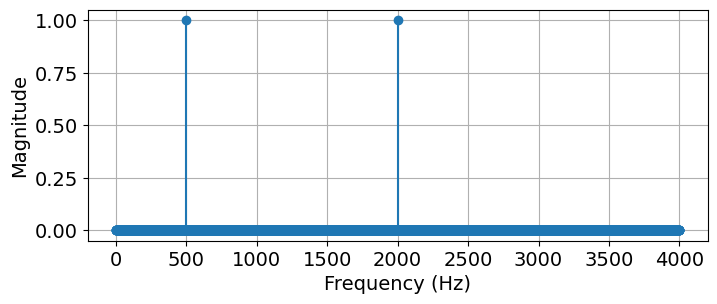

Spectral centroid: 1250.0 Hz
Spectral spread:   750.0 Hz


In [35]:
# Calcolo dello spettro di ampiezza

fs = 8000
fa = 500
fb = 2000
t = np.linspace(0, 1.0, fs, endpoint=False)
signal = np.sin(2*np.pi* fa *t) + np.sin(2*np.pi* fb *t)

plt.figure(figsize=(8,3))
spectrum, freqs = dft(signal, fs)
"""
L = len(signal)
freqs = np.fft.rfftfreq(L, 1/fs)
spectrum = np.abs(np.fft.rfft(signal)) / (L/2)
"""
plt.stem(freqs, spectrum, basefmt=" ")
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.show()

centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * spectrum) / np.sum(spectrum))
print(f"Spectral centroid: {centroid:.1f} Hz")
print(f"Spectral spread:   {spread:.1f} Hz")

In [36]:
audio_path = "media/piano.wav"

piano = 'media/piano.wav'
trumpet = 'media/trumpet.wav'
violin = "media/violin.wav"
flute = "media/flute.wav"

for audio_path in [piano, trumpet, violin, flute]:
  y, sr = librosa.load(audio_path, sr=None)


  plt.figure(figsize=(12,3))
  spectrum, freqs = dft(y, sr)
  """
  L = len(y)
  freqs = np.fft.rfftfreq(L,1/sr)
  spectrum = np.abs(np.fft.rfft(y))/(L/2)
  """

  plt.stem(freqs, spectrum, basefmt=" ", markerfmt=" ")
  centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
  plt.plot(centroid, np.max(spectrum), 'o')
  plt.ylabel(audio_path)
  #plt.ylabel('Magnitude')
  #plt.xlabel('Frequency (Hz)')
  plt.grid()
  plt.show()

  print(f"Spectral centroid: {centroid:.1f} Hz")
  print(f"Spectral spread: {spread:.1f} Hz")


/tmp/ipython-input-3290475770.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'media/piano.wav'

[Text(0.5, 1.0, 'log Power spectrogram')]

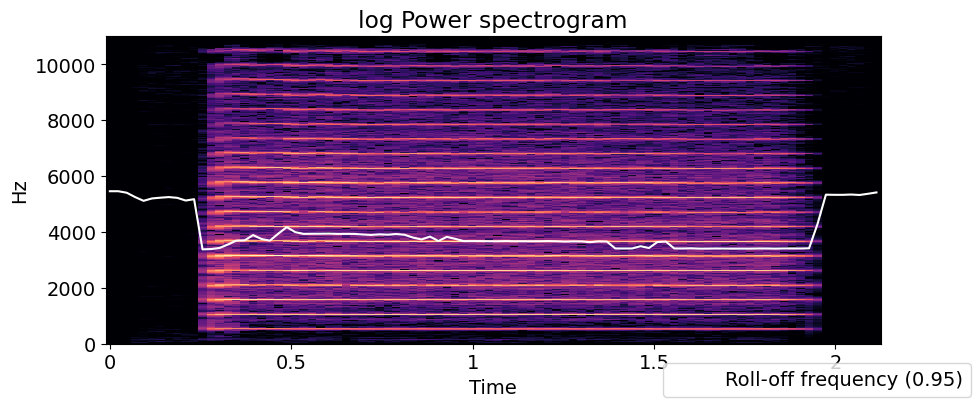

In [ ]:
# Spectral roll-off (via librosa)
audio_path = "media/trumpet.wav"
percent = 0.95
y, sr = librosa.load(audio_path, sr=None)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=percent)
S, phase = librosa.magphase(librosa.stft(y))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='linear', x_axis='time', ax=ax)
ax.plot(librosa.times_like(rolloff), rolloff[0], label=f'Roll-off frequency ({percent})', color='w')
# ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
fig.legend(loc='outside lower right')
ax.set(title='log Power spectrogram')


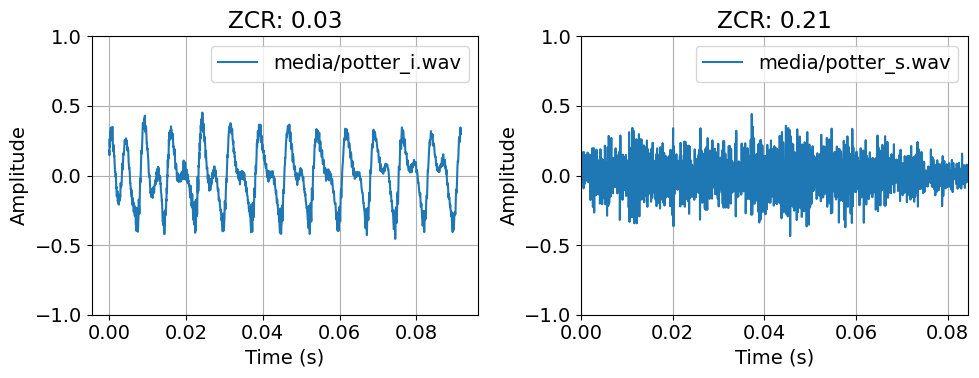

In [ ]:
# zero crossing rate

def zcr(x):
  # x [1, -1, -0.5, 1, -1]
  # sign [ 1. -1. -1. 1. -1.]
  # diff [-2. 0. 2. -2.]
  # count_nonzero 3
  # zcr 0.6 # i.e. 3/5
  return np.count_nonzero(np.diff(np.sign(x))) / len(x)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

audio_path = "media/potter_i.wav"
y, sr = librosa.load(audio_path, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y, t, fig=(fig,ax1))
ax1.set_title(f"ZCR: {zcr(y):.2f}")
ax1.legend([audio_path])

audio_path = "media/potter_s.wav"
y, sr = librosa.load(audio_path, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y, t, fig=(fig,ax2))
ax2.set_title(f"ZCR: {zcr(y):.2f}")
ax2.legend([audio_path])



Spectral flatness ((0.00)*noise + 1.00*tone):  0.000000


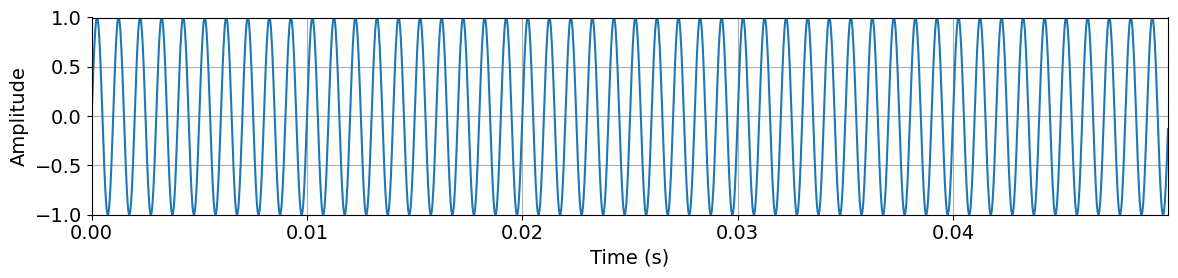

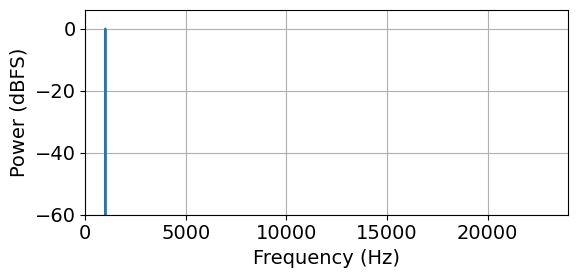

In [37]:
import numpy as np
import scipy.signal as signal

def spectral_flatness(amplitude):
    # Avoid log(0)
    amplitude = np.maximum(amplitude, 1e-12)
    geometric_mean = np.exp(np.mean(np.log(amplitude)))
    arithmetic_mean = np.mean(amplitude)
    return geometric_mean / arithmetic_mean

# Example signals
fs = 48000
t = np.linspace(0, 0.05, int(fs*0.05), endpoint=False)

# A pure sinusoid (tone)
tone = signal.sawtooth(2*np.pi*1000*t)
tone = np.sin(2*np.pi*1000*t)


# White noise
noise = np.random.randn(len(t))

a = 1
signal = (1 - a)*noise + a*tone
t = np.arange(len(signal))/fs
spectrum, freqs = dft(signal, fs)
"""
L = len(signal)
spectrum = np.abs(np.fft.rfft(signal))/(L/2)
freqs = np.fft.rfftfreq(len(signal), 1/fs)
"""
flatness = spectral_flatness(spectrum)

plot_vs_time(signal, t)
plot_vs_freq(spectrum, freqs, fs, type="log")

print(f"Spectral flatness (({1-a:.2f})*noise + {a:.2f}*tone):  {flatness:.6f}")


# Segmentazione

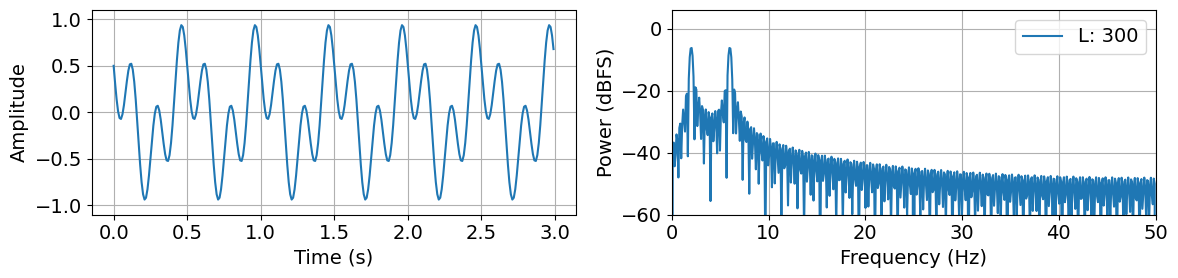

In [32]:

Fs = 100
dur = 3

# tono 2 Hz
x1, t1 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)
# tono 6 Hz
x2, t2 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=6, phase=np.pi/2)


# Media somma dei toni
x = np.average([x1, x2], axis=0)
t = t1

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,3))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax1), fmt='-')
X, f = dft(x, Fs, N=1024)
plot_vs_freq(X, f, Fs, type="log", fig=(fig,ax2))

ax2.legend([f"L: {len(x)}"])
plt.show()





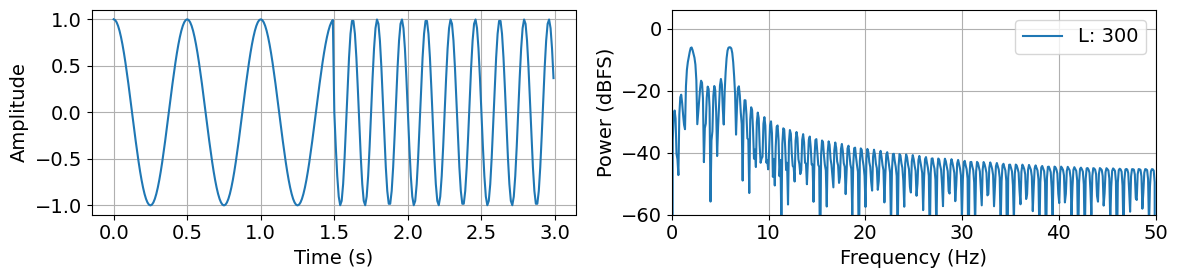

In [34]:

Fs = 100
dur = 3/2

# tono 2 Hz
x1, t1 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)
# tono 6 Hz
x2, t2 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=6, phase=np.pi/2)

# Concatenazione dei toni
x = np.concatenate([x1, x2], axis=0)
t = np.arange(len(x))/Fs

# x = x2
# t = t2

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,3))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax1), fmt='-')
X, f = dft(x, Fs, N=1024)
plot_vs_freq(X, f, Fs, type="log", fig=(fig,ax2))

ax2.legend([f"L: {len(x)}"])
plt.show()



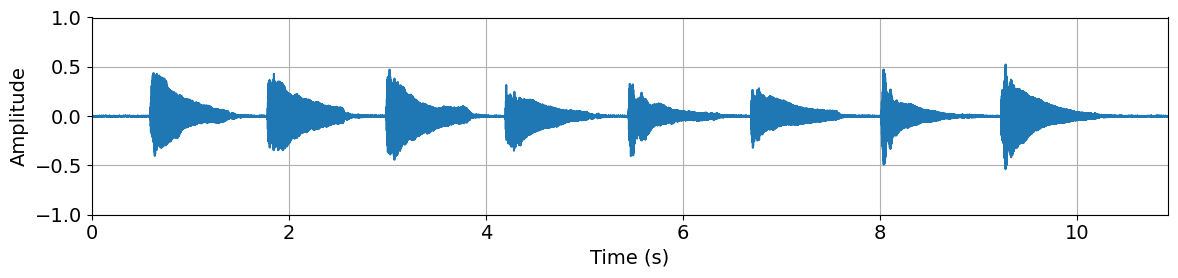

In [ ]:
audio_path = "media/piano-major-scale.wav"
y, sr = librosa.load(audio_path, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y,t)